<a href="https://colab.research.google.com/github/Petrichoeur/Dashboard_ter/blob/master/deep_learning/articulatory_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
PATH ='drive/My Drive/data/'
from google.colab import drive
drive.mount('/content/drive')
!nvidia-smi

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Sat May  2 15:37:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================

In [0]:
import pandas as pd 
import numpy as np 
import joblib 
import os  
from collections import Counter 
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import roc_auc_score ,roc_curve
from ipywidgets import interact
import seaborn as sns   
from IPython.display import clear_output
def DNtocat(x): 
    if x!=1:
        return 0 
    else : 
        return 1


In [3]:
DATA=joblib.load(PATH+'articulatorydata.job')

print('row is word') 
print('columns is articulatory feature') 
dfdic=joblib.load(PATH+'final_data.job') 
print('dfdic is original data ')

row is word
columns is articulatory feature
dfdic is original data 


In [4]:
from keras.models import Sequential, Model
from keras.layers import LSTM,Conv1D,MaxPooling1D, GlobalMaxPool1D, Input,Flatten,Conv2D
from keras.layers import Dense, MaxPooling2D,Reshape
from keras.layers import RepeatVector, Concatenate
from keras.layers import TimeDistributed
from keras.utils import plot_model

Using TensorFlow backend.


In [10]:
def model_dl():
    
    inputseq = Input(shape=(14, 14,1),name='input')  
    
    # Convolution on one axis 
    conv1_1=Conv2D(filters=32,kernel_size=(2,1),padding='valid',activation='relu',name='c11')(inputseq)
    pool1_1=MaxPooling2D(pool_size=(2,1),padding='same',name='Mp11')(conv1_1)  
    conv1_2=Conv2D(filters=32,kernel_size=(2,1),padding='valid',name='c12',activation='relu')(pool1_1) 
    pool1_2=MaxPooling2D(pool_size=(2,1),padding='same',name='Mp12')(conv1_2)
    flat1= Flatten(name='flat1')(pool1_2) 

    
    
    #Convolution on other axis  
    
    conv2_1=Conv2D(filters=32,kernel_size=(1,2),padding='valid',activation='relu',name='c21')(inputseq)
    pool2_1=MaxPooling2D(pool_size=(1,2),padding='same',name='mp21')(conv2_1)  
    conv2_2=Conv2D(filters=32,kernel_size=(1,2),padding='valid',name='c22',activation='relu')(pool2_1) 
    pool2_2=MaxPooling2D(pool_size=(1,2),padding='same',name='mp22')(conv2_2)
    flat2= Flatten(name='flat2')(pool2_2)  
    
    # Concatenate two layers 
    
    Concat =Concatenate()([flat1,flat2])
    
    dense=Dense(1,activation='sigmoid')(Concat) 
    
    model= Model(inputseq, dense)
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy']) 
    return model
model_dl().summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 14, 14, 1)    0                                            
__________________________________________________________________________________________________
c11 (Conv2D)                    (None, 13, 14, 32)   96          input[0][0]                      
__________________________________________________________________________________________________
c21 (Conv2D)                    (None, 14, 13, 32)   96          input[0][0]                      
__________________________________________________________________________________________________
Mp11 (MaxPooling2D)             (None, 7, 14, 32)    0           c11[0][0]                        
____________________________________________________________________________________________

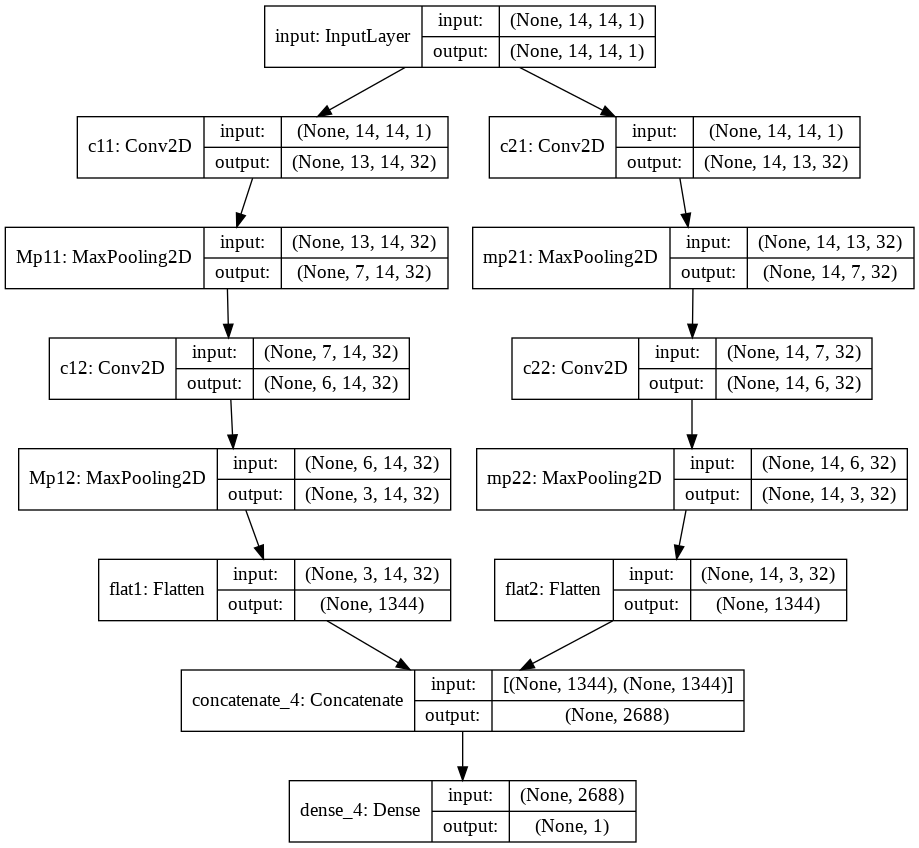

In [11]:
plot_model(model_dl(),show_shapes=True, expand_nested=True)

# Test with all 

In [0]:
X_age={} 
Y_age={}
for idage in range(2,5): 

    ConteneurX=[] 
    ConteneurY=[]
    for idx, key in enumerate(dfdic.keys()):
        boolist=dfdic[key].age==idage
        ConteneurX.append(DATA['true_chi'][key][boolist])  # Seulement ce que l'enfant aurait du dire 
        ConteneurY.append(dfdic[key]['NDL'].values[boolist])
    X=np.concatenate(ConteneurX,axis=0)
    X=X.reshape(*X.shape,1)
    #X_true=DATA['true_chi']['julie'][boolist] 
    #X_true=X_true.reshape(*X_true.shape,1) 

    Y=np.concatenate(ConteneurY,axis=0)
    Y=(Y==1)*1  
    X_age[idage]=X 
    Y_age[idage]=Y  

In [0]:
class Age_analyse(): 
    def __init__(self,X_age,Y_age): 
        self.X_age=X_age 
        self.Y_age=Y_age
        self.X_train= {} 
        self.Y_train={}
        self.X_test={}
        self.Y_test={}
        self.history= {}
        self.model={}
        self.Y_testpredict={}
        self.KEYS= X_age.keys()
    def __pre_model(self,shuffle=True,train_size=0.9):  
        for i in self.KEYS :
            self.model[i] =model_dl()    
            x_train,x_test,y_train,y_test=train_test_split(self.X_age[i],self.Y_age[i],shuffle=shuffle,train_size=train_size) 
            self.X_train[i]=x_train 
            self.Y_train[i]=y_train
            self.X_test[i]=x_test
            self.Y_test[i]=y_test
    def train(self,train_size=0.9,shuffle=True,batch_size=16,epochs=200,validation_split=0.05):  
        self.__pre_model(shuffle=shuffle,train_size=train_size)
        for i in self.KEYS :  
            
            for epo in range(epochs//2):
                print(f' Work with  age : {i}  epochs = {(epo+1)*2} / {epochs} ') 
                self.model[i].fit(self.X_train[i],self.Y_train[i],batch_size=batch_size,epochs=2,validation_split=validation_split)   
                try : 
                    clear_output(wait=True) 
                except: 
                    pass 
            self.Y_testpredict[i]=self.model[i].predict(self.X_test[i]) 
            try : 
                clear_output(wait=True) 
            except : 
                pass 
    def eval_model(self,key):  
        y_test=self.Y_test[key] 
        pred =self.Y_testpredict[key]
        rocauc=roc_auc_score(y_test,np.round(pred))
        print('CLASSIFICATION REPORT ')
        print('===========================================')
        print('===========================================')
        print(classification_report(y_test,np.round(pred))) 
        print('===========================================')
        print('===========================================')

        print(f' ROC_AUC_SCORE ON VALIDATION DATA: {rocauc}')  
        print(f'GINI SCORE ON VALIDATION DATA : {2*rocauc-1}')
        fpr,tpr,tres = roc_curve(y_test,pred) 
        fig,ax= plt.subplots()
        ax.plot(fpr,tpr)
        ax.plot([-1, 1], [-1, 1], color='navy', linestyle='--')
        ax.set_xlabel('false positive rate')
        ax.set_ylabel('True positive rate ') 
        ax.set_title(f'Roc_auc curve for model at age : {key}')
        ax.plot([0, 0], [-1, 1], color='navy', linestyle='--')
        ax.plot([-1, 1], [0, 0], color='navy', linestyle='--') 
        plt.show() 
        

 



In [0]:
Total_age= Age_analyse(X_age,Y_age)

In [15]:
Total_age.train()

 Work with  age : 4  epochs = 200 / 200 
Train on 6279 samples, validate on 331 samples
Epoch 1/2
6279/6279 [==============================] - 2s 260us/step - loss: 0.3110 - accuracy: 0.8670 - val_loss: 0.3696 - val_accuracy: 0.8399
Epoch 2/2
6279/6279 [==============================] - 2s 265us/step - loss: 0.3139 - accuracy: 0.8642 - val_loss: 0.3719 - val_accuracy: 0.8338


# Evaluating each model for each age 

_____________________________________________
_____________________________________________
_____________________________________________
 Evaluation for near 2 years old childs  


CLASSIFICATION REPORT 
              precision    recall  f1-score   support

           0       0.80      0.66      0.72       568
           1       0.81      0.89      0.85       896

    accuracy                           0.80      1464
   macro avg       0.80      0.78      0.79      1464
weighted avg       0.80      0.80      0.80      1464

 ROC_AUC_SCORE ON VALIDATION DATA: 0.777972522635815
GINI SCORE ON VALIDATION DATA : 0.5559450452716299


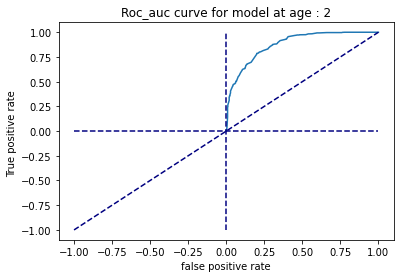

_____________________________________________
_____________________________________________
_____________________________________________
_____________________________________________
_____________________________________________
_____________________________________________
 Evaluation for near 3 years old childs  


CLASSIFICATION REPORT 
              precision    recall  f1-score   support

           0       0.79      0.74      0.77       401
           1       0.86      0.89      0.87       691

    accuracy                           0.83      1092
   macro avg       0.82      0.82      0.82      1092
weighted avg       0.83      0.83      0.83      1092

 ROC_AUC_SCORE ON VALIDATION DATA: 0.8151311302063221
GINI SCORE ON VALIDATION DATA : 0.6302622604126442


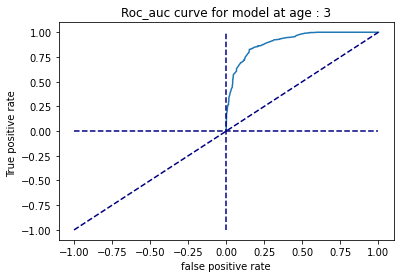

_____________________________________________
_____________________________________________
_____________________________________________
_____________________________________________
_____________________________________________
_____________________________________________
 Evaluation for near 4 years old childs  


CLASSIFICATION REPORT 
              precision    recall  f1-score   support

           0       0.86      0.76      0.81       257
           1       0.88      0.93      0.90       478

    accuracy                           0.87       735
   macro avg       0.87      0.85      0.86       735
weighted avg       0.87      0.87      0.87       735

 ROC_AUC_SCORE ON VALIDATION DATA: 0.8459046285593343
GINI SCORE ON VALIDATION DATA : 0.6918092571186687


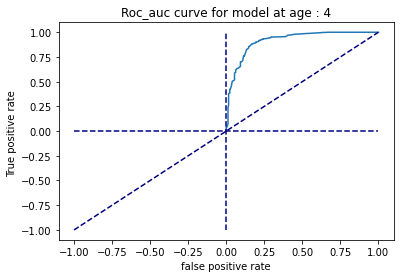

_____________________________________________
_____________________________________________
_____________________________________________


In [23]:
for i in [2,3,4]:  
    print('_____________________________________________')
    print('_____________________________________________')
    print('_____________________________________________')
    print (f' Evaluation for near {i} years old childs  ')
    print('\n')
    Total_age.eval_model(i)
    print('_____________________________________________')
    print('_____________________________________________')
    print('_____________________________________________')